In [2]:
####Install necessary packages
!pip3 install geocoder
!pip3 install fastparquet
!pip3 install -U google-api-core
!pip3 install --upgrade pip
!pip3 install --upgrade google-cloud-language
!pip3 install --upgrade google-cloud-bigquery
!pip3 install -t lib/ --upgrade google-api-python-client
!pip3 install -t lib/ --upgrade google-cloud

Requirement already up-to-date: google-api-core in /usr/local/envs/py3env/lib/python3.5/site-packages (1.13.0)
Requirement already up-to-date: pip in /usr/local/envs/py3env/lib/python3.5/site-packages (19.1.1)
Requirement already up-to-date: google-cloud-language in /usr/local/envs/py3env/lib/python3.5/site-packages (1.2.0)


Requirement already up-to-date: google-cloud-bigquery in /usr/local/envs/py3env/lib/python3.5/site-packages (1.16.0)
  Using cached https://files.pythonhosted.org/packages/3f/f1/20fd18744c3d20307d634ffcc02592bc7efc45a59624e14655cf21cbfb5e/google_api_python_client-1.7.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a8/12/213dee680d0e7d5689e3ef20c857f72932964c9d369ec50fbc39906fc757/httplib2-0.13.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/33/49/c814d6d438b823441552198f096fcd0377fd6c88714dbed34f1d3c8c4389/google_auth_httplib2-0.0.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e5/7d/9d5a640c4f8bf2c8b1afc015e9a9d8de32e13c9016dcc4b0ec03481fb396/uritemplate-3.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c5/9b/ed0516cc1f76

In [1]:
###Import the necessary libraries
#import geocoder
from google.cloud import language_v1
from google.cloud.language_v1 import enums
from google.cloud.language import types
import six
from google.cloud import bigquery
import pandas as pd
client = bigquery.Client(location='US')
client2 = language_v1.LanguageServiceClient()

In [2]:
####Define the needed functions
def classify_score(num, threshold=0.3):
###Classifies sentiment according to a threshold set###
  if (num>threshold):
    return "positive"
  elif (num<-threshold):
    return "negative"
  else:
    return "neutral"
  
def generate_sentiment_score(content, lang="es", client_type=client2):
###Inputs: text (content, language to return the sentiment analysis (lang), and the client generated for the sentiment analysis (client_type)
###      Outputs:the sentiment score (from -1 to 1, 1 being absolute positive and -1 being absolutely negative)###
    if isinstance(content, six.binary_type):
        content = content.decode('utf-8')
    type_ = enums.Document.Type.PLAIN_TEXT
    document = {'type': type_, 'content': content, "language": lang}
    response = client_type.analyze_sentiment(document)
    sentiment = response.document_sentiment
    return sentiment.score

In [3]:
####Query the data
sql=""" 
( 
SELECT
    distinct item_id,
    title,
    date as fecha,
    text_content,
    'Semana' AS source
  FROM
    `servisentimen-servipolitics.news_scrapping.semana`
  WHERE
    REGEXP_CONTAINS(LOWER(text_content),
      r'santrich') )
  UNION ALL (
  SELECT
    distinct item_id, 
    title,
    cast(date as DATE) as fecha,
    text_content,
    'El Tiempo' AS source
  FROM
    `servisentimen-servipolitics.news_scrapping.el_tiempo`
  WHERE
    REGEXP_CONTAINS(LOWER(text_content),
      r'santrich') )
  UNION ALL (
  SELECT
    distinct item_id, 
    title,
    date as fecha,
    text_content,
    'El Espectador' AS source
  FROM
    `servisentimen-servipolitics.news_scrapping.el_espectador`
  WHERE
    REGEXP_CONTAINS(LOWER(text_content),
      r'santrich') )
"""
df = client.query(sql).to_dataframe()
df.head()

,item_id,title,fecha,text_content,source
0,868966,"La Iglesia, preocupada por la implementación d...",2019-07-03,""":""La Iglesia, preocupada por la implementació...",El Espectador
1,869016,Caso “Santrich” no erosiona proceso de reincor...,2019-07-03,""":""Caso Santrich no erosiona proceso de reinco...",El Espectador
2,869031,Exsenador Luis Alberto Gil seguirá detenido en...,2019-07-03,""":""Caso Bermeo: exsenador Luis Alberto Gil seg...",El Espectador
3,867099,"""Duque debe limitar su relaciÃ³n con Uribe"": T...",2019-06-21,""":""u0022Duque debe limitar su relación con Uri...",El Espectador
4,868066,Indagatoria contra JesÃºs Santrich por narcotr...,2019-06-27,""":""Indagatoria contra Jesús Santrich por narco...",El Espectador


In [4]:
####Apply transformations
df['score']=df['text_content'].apply(generate_sentiment_score)
df['classification']=df['score'].apply(classify_score)

In [5]:
####Start analyzing
df.head()

,item_id,title,fecha,text_content,source,score,classification
0,868966,"La Iglesia, preocupada por la implementación d...",2019-07-03,""":""La Iglesia, preocupada por la implementació...",El Espectador,0.2,neutral
1,869016,Caso “Santrich” no erosiona proceso de reincor...,2019-07-03,""":""Caso Santrich no erosiona proceso de reinco...",El Espectador,-0.6,negative
2,869031,Exsenador Luis Alberto Gil seguirá detenido en...,2019-07-03,""":""Caso Bermeo: exsenador Luis Alberto Gil seg...",El Espectador,-0.2,neutral
3,867099,"""Duque debe limitar su relaciÃ³n con Uribe"": T...",2019-06-21,""":""u0022Duque debe limitar su relación con Uri...",El Espectador,-0.1,neutral
4,868066,Indagatoria contra JesÃºs Santrich por narcotr...,2019-06-27,""":""Indagatoria contra Jesús Santrich por narco...",El Espectador,-0.2,neutral


In [6]:
df.describe()

,item_id,score
count,36.000000,36.000000
mean,678102.750000,-0.052778
std,203013.502904,0.168160
min,373896.000000,-0.600000
25%,561545.750000,-0.100000
50%,621665.000000,0.000000
75%,868737.250000,0.100000
max,869031.000000,0.200000


In [7]:
df.groupby('source').count()

,item_id,title,fecha,text_content,score,classification
source,,,,,,
El Espectador,17,17,17,17,17,17
El Tiempo,9,9,9,9,9,9
Semana,10,10,10,10,10,10


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
df.groupby('source').mean()

,item_id,score
source,,
El Espectador,868612.588235,-0.064706
El Tiempo,381203.777778,0.000000
Semana,621445.100000,-0.080000


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


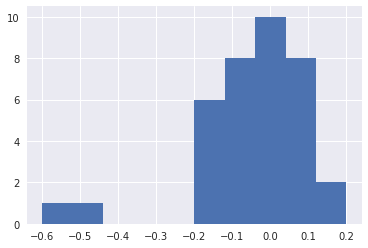

In [10]:
df['score'].hist()

In [15]:
###Convertir fecha
df['fecha']=df['fecha'].apply(lambda x: str(x))

In [16]:
dataset_id = 'temp_outputs'
dataset = client.dataset(dataset_id)
table_ref = dataset.table('sentiment_v2')
load_job = client.load_table_from_dataframe(df, table_ref)
load_job.result()  # Waits for table load to complete.
